In [1]:
import torch
import torchvision
from torch import nn
from matplotlib import pyplot as plt
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('target1.png')
d2l.plt.imshow(content_img);


OSError: [WinError 1455] 页面文件太小，无法完成操作。 Error loading "d:\conda\envs\d2l\lib\site-packages\torch\lib\cusparse64_11.dll" or one of its dependencies.

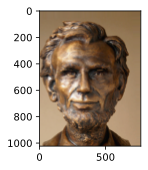

In [ ]:

style_img = d2l.Image.open('target1_lincolnbust_3x3_voting_bg.png')
d2l.plt.imshow(style_img);


In [ ]:

rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0) #图片转tensor

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1)) #tensor转图片
device, image_shape = d2l.try_gpu(), (768, 1024)
content_X = preprocess(content_img, image_shape).to(device)

In [4]:

pretrained_net = torchvision.models.vgg19(pretrained=True)

style_layers, content_layers = [0, 5, 10, 19, 28], [25]

net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

def extract_features(X, content_layers, style_layers): #特征与样式抽取
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

    
def get_contents(image_shape, device): #特征抽取
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device): #样式抽取
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y


定义损失函数

In [5]:

def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())
